<a href="https://colab.research.google.com/github/kavyajeetbora/end_to_end_gee_with_python/blob/master/Development/District-Builtup-Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

In [12]:
# Define the time range.
start_date = '1980-01-01'
end_date = '2024-12-31'

# Load the GAUL dataset for second-level administrative units
gaul_dataset = ee.FeatureCollection('FAO/GAUL/2015/level2')
# Filter the dataset to get the boundary of Goa
boundary = gaul_dataset.filter(ee.Filter.eq('ADM1_NAME', 'Delhi'))
boundary.size()

## Merge the landsat image collection


- We will merge the landsat images from landsat 5 to landsat 9.
- We will filter the image collection by cloud cover, we want only clean images
- Also print the starting date and ending date of the available image collections

Which images to consider for cloud free images ?

Recommendation:
1. For General Land Cover Mapping and Long-Term Monitoring: Use the Median Composite method to ensure consistent and robust results, especially in areas with frequent cloud cover.
2. For Time-Series Analysis and Short-Term Changes: Use Zero Cloud Cover Images to maintain temporal precision and clarity.

In [13]:
# Load the Landsat image collections including Landsat 9.
landsat_collections = [
    "LANDSAT/LT05/C02/T1_L2",  # Landsat 5
    "LANDSAT/LE07/C02/T1_L2",  # Landsat 7
    'LANDSAT/LC08/C02/T1_L2',  # Landsat 8
    'LANDSAT/LC09/C02/T1_L2'   # Landsat 9
]

landsat_images = ee.ImageCollection([])
for collection in landsat_collections:
    landsat_images = landsat_images.merge(
        ee.ImageCollection(collection)
        .filterDate(start_date, end_date)\
        .filterBounds(boundary)\
        .filter(ee.Filter.lt("CLOUD_COVER", 5))  ## images with less than 5% cloud clover
    )

# Print the number of images in the combined Landsat collection.
print('Number of images in Landsat collection:', landsat_images.size().getInfo())

first_image = landsat_images.sort('system:time_start', True).first()
last_image = landsat_images.sort('system:time_start', False).first()

date1 = first_image.get('DATE_ACQUIRED').getInfo()
date2 = last_image.get('DATE_ACQUIRED').getInfo()

print(f"Images collection are from date: {date1} to {date2}")

Number of images in Landsat collection: 862
Images collection are from date: 1989-08-06 to 2024-10-10


## Apply scale and offset to Landsat Bands (SR_B1 to SR_B7)

In [14]:
# Applies scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )

# Map the function to the image collection
scaled_landsat_images = landsat_images.map(apply_scale_factors)

## Get the number of images for each year

In [15]:
# Function to get the year from the image date
def get_year(image):
    return ee.Date(image.get('system:time_start')).get('year')

# Map the function over the image collection to get the list of years
years = scaled_landsat_images.map(lambda image: image.set('year', get_year(image)))

# Reduce the collection by year to count the number of images per year
year_counts = years.aggregate_histogram('year')

# Print the number of images for each year
print('Number of images for each year:', year_counts.getInfo())

Number of images for each year: {'1989': 3, '1990': 4, '1991': 7, '1992': 8, '1993': 16, '1994': 13, '1995': 5, '1996': 12, '1997': 6, '1998': 17, '1999': 13, '2000': 17, '2001': 14, '2002': 11, '2003': 13, '2004': 20, '2005': 19, '2006': 13, '2007': 19, '2008': 20, '2009': 37, '2010': 32, '2011': 25, '2012': 16, '2013': 30, '2014': 36, '2015': 38, '2016': 36, '2017': 49, '2018': 49, '2019': 37, '2020': 41, '2021': 37, '2022': 67, '2023': 56, '2024': 26}


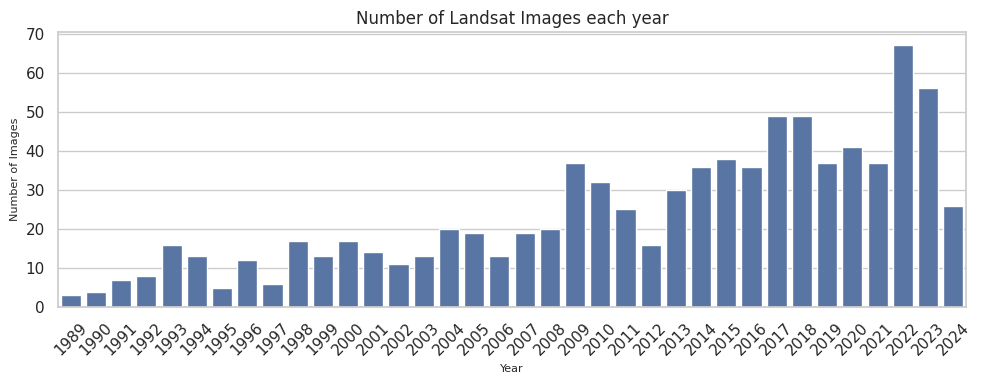

In [16]:
# Function to plot a bar plot from a dictionary
def plot_bar_from_dict(data_dict):
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(list(data_dict.items()), columns=['Category', 'Value'])

    # Set the style of the plot
    sns.set(style="whitegrid")

    # Create the bar plot
    plt.figure(figsize=(10, 4))
    bar_plot = sns.barplot(x='Category', y='Value', data=df)

    # Add titles and labels
    bar_plot.set_title('Number of Landsat Images each year', fontsize=12)
    bar_plot.set_xlabel('Year', fontsize=8)
    bar_plot.set_ylabel('Number of Images', fontsize=8)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()


plot_bar_from_dict(year_counts.getInfo())

## Find the yearly composites


- We will find the median composites for each year to get cloud free images
- we will determine this for each year

In [17]:
def get_yearly_composites(image_collection):

    yearly_composites = []
    for year in year_counts.getInfo().keys():
        start_date = ee.Date.fromYMD(int(year), 1, 1)
        end_date = ee.Date.fromYMD(int(year) + 1, 1, 1)

        img_col = image_collection.filterDate(start_date,end_date)

        first_image = img_col.first()

        median_composite = img_col.median().set('year', year) #.copyProperties(first_image)
        yearly_composites.append(median_composite)

    yearly_composites = ee.ImageCollection.fromImages(yearly_composites)
    return yearly_composites

yearly_composites = get_yearly_composites(scaled_landsat_images)

# Print the number of images in the yearly image collection
print('Number of images in yearly image collection:', yearly_composites.size().getInfo())

Number of images in yearly image collection: 36


## Visualizing the results

In [24]:
first_image = yearly_composites.first()
last_image = yearly_composites.sort('year', False).first()

# Create a map and display the first image
Map = geemap.Map()
Map.centerObject(boundary, 10)

visualization = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.0,
    'max': 0.3,
}
visualization = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'], # Use red, green, and blue bands
    'min': 0.0,
    'max': 0.3,
}
title = f"Year: {last_image.get('year').getInfo()}"

Map.addLayer(last_image.clip(boundary), visualization, title)
Map.addLayerControl()
Map

Map(center=[28.646455931994893, 77.10900424302301], controls=(WidgetControl(options=['position', 'transparent_…